In [1]:

import argparse
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abcclassify.abcclassify as abcc
import csv
import os.path
from sklearn import tree


In [2]:

participant = abcc.videotracking(framerange=(10530, 15611))
participant.addtrackingdata("/home/zzalsdme/IDInteraction/paper/results/OpenFace/P01_front.openface")
groundtruth = abcc.loadExternalGroundTruth("/home/zzalsdme/IDInteraction/paper/results/Groundtruth/P01_attention.csv", participant)
# All the potential training frames
trainingframes = participant.frames
np.random.shuffle(trainingframes)
participant.setClassificationMethod("random")
cvfolds = 5


Loading tracking data from: /home/zzalsdme/IDInteraction/paper/results/OpenFace/P01_front.openface
OpenFace input detected


We want to explore different approaches to training the classifier.  We've already looked at sequential and random, and shown that random classification leads to much better performance.  

Rob suggested looking at areas that had poor performance, and focussing on these.  If we've got ground truth we *know* where has poor performance. Normally though we'll need to use cross validation to estimate the performance of the classifier


We want a window size such that the cross-validation scores are resonably stable.



In [3]:
batchsize = 100
windowsize = 2000 # Number of (total - classified and unclassified) frames in each window
advancesize = 250  # The amount to advance each window by
# overlap between adjacent windows will be windowsize - advancesize

def trainRegion(participant, groundtruth):
    """Apply the groundtruth data to a participant"""
    for index,row in groundtruth.iterrows():
        participant.setClassification(index, row["state"], testunset = True)
        

def calcWindowedAccuracy(participant, windowsize, advancesize):
    """Test the xval accuracy of overlapping windows within the object"""
    firstframe = min(participant.frames)
    lastframe = max(participant.frames)

    windowstarts = range(firstframe, lastframe - windowsize, advancesize)

    means=[]
    stds = []
    numframes = []
    for fr in windowstarts:
        thispart = participant.split((fr, fr + windowsize))
        try: 
            thispartvtc = abcc.videotrackingclassifier(thispart)
            xvalscore = thispartvtc.getCrossValidatedScore(cv = cvfolds)
        except ValueError:
            xvalscore = np.array([np.NaN])
        means.append(xvalscore.mean())
        stds.append(xvalscore.std())
        numframes.append(len(thispart.getClassifiedFrames()))

    
    results = pd.DataFrame.from_items([("startframe", windowstarts),
                                  ("mean", means),
                                  ("std", stds),
                                  ("numclassframes", numframes)])
    
    return results


# Perform initial training with batchsize frames
trainRegion(participant, groundtruth.loc[trainingframes[:(2*batchsize)]])

for i in range(1,4):
    results = calcWindowedAccuracy(participant, batchsize, windowsize)
    
    print results

    
    # Find the minimum accuracy startframe
    # TODO - handle tiebreaks - pick at random
    minstartframe = results["startframe"].iloc[np.nanargmin(results["mean"])]
    
    # Get frames we to classify in this range
    trainingframes = list(set(range(minstartframe, minstartframe + windowsize)) - \
                      set(participant.getClassifiedFrames().index))

    np.random.shuffle(trainingframes)
        
    traindata = groundtruth.loc[trainingframes[:batchsize]]
    trainRegion(participant, traindata)

    vtc = abcc.videotrackingclassifier(participant)
    xvalscore = vtc.getCrossValidatedScore(cv=cvfolds)
    print str(minstartframe) + " " + str(vtc.vto.numClassifiedFrames()) + " "+ str(xvalscore.mean()) + " " + str(xvalscore.std())
      
    
    



   startframe  mean  std  numclassframes
0       10530     1    0               7
1       12530   NaN  NaN               2
2       14530   NaN  NaN               1
10530 300 0.85 0.073029674334
   startframe  mean  std  numclassframes
0       10530   0.9  0.2              12
1       12530   NaN  NaN               2
2       14530   NaN  NaN               1
10530 400 0.8575 0.0331662479036
   startframe      mean       std  numclassframes
0       10530  0.933333  0.133333              13
1       12530       NaN       NaN               2
2       14530       NaN       NaN               1
10530 500 0.876 0.0338230690506


We see that accuracy tends to improve, and varition between x-val folds decreases.
Now we define a moving window function, to extract specific subsets of the data.  We pull out subsets with a constant number of frames (TODO ones at end???), regardless of how many frames have been classified within them.  





firstframe = min(participant.frames)
lastframe = max(participant.frames)

windowstarts = range(firstframe, lastframe - windowsize, advancesize)

means=[]
stds = []
for fr in windowstarts:
    thispart = participant.split((fr, fr + windowsize))
    try: 
        thispartvtc = abcc.videotrackingclassifier(thispart)
        xvalscore = vtc.getCrossValidatedScore(cv = cvfolds)
    except ValueError:
        xvalscore = np.array([np.NaN])
    means.append(xvalscore.mean())
    stds.append(xvalscore.std())

    
results = pd.DataFrame.from_items([("startframe", windowstarts),
                                  ("mean", means),
                                  ("std", stds)])


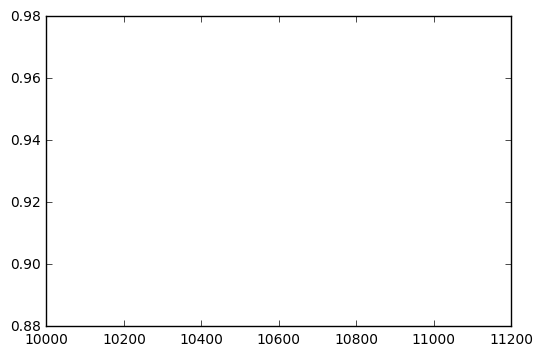

In [4]:
plt.plot(results["startframe"], results["mean"])

plt.show()


In [5]:
# Find the minimum startframe
minstartframe = results["startframe"].iloc[results["mean"].argmin()]

# Get frames we to classify in this range
trainingframes = list(set(range(minstartframe, minstartframe + windowsize)) - \
                      set(participant.getClassifiedFrames().index))
print len(trainingframes)
np.random.shuffle(trainingframes)



1624
